In [8]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

from tensorflow.keras.utils import to_categorical

from medmnist import BloodMNIST

2024-05-15 12:23:58.896232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 12:24:00.312555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/toffanetto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [58]:
# Importing data

INPUT_N = 28

train_dataset = BloodMNIST(split="train", download=True, size=INPUT_N)

X_train_full = np.zeros([len(train_dataset), INPUT_N, INPUT_N, 3]) 

y_train_full = np.zeros([len(train_dataset), 1])

for i in range(len(train_dataset)):
    x, y_train_full[i] = train_dataset[i]
    X_train_full[i] = np.array(x)/255.0
    
i_val = int(len(train_dataset)*0.7)

X_train = X_train_full[:i_val]
y_train = y_train_full[:i_val]

X_val = X_train_full[i_val:]
y_val = y_train_full[i_val:]

print('Number of samples in train dataset: '+str(len(train_dataset)))

print('Shape of data in train dataset: '+str(X_train.shape)+" "+str(y_train.shape))

print('Shape of data in validation dataset: '+str(X_val.shape)+" "+str(y_val.shape))

test_dataset = BloodMNIST(split="test", download=True, size=INPUT_N)

X_test = np.zeros([len(test_dataset), INPUT_N, INPUT_N, 3])

y_test = np.zeros([len(test_dataset), 1])

for i in range(len(test_dataset)):
    x, y_test[i] = test_dataset[i]
    X_test[i] = np.array(x)/255.0

print('Number of samples in test dataset: '+str(len(test_dataset)))

print('Shape of data in test dataset: '+str(X_test.shape)+" "+str(y_test.shape))

classes_labels = ['Basófilos - 0', 'Eosinófilos - 1', 'Eritroblastos - 2', 'Granulócitos imaturos - 3',
                  'Linfócitos - 4', 'Monócitos - 5', 'Neutrófilos - 6', 'Plaquetas - 7']


Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in train dataset: 11959
Shape of data in train dataset: (8371, 28, 28, 3) (8371, 1)
Shape of data in validation dataset: (3588, 28, 28, 3) (3588, 1)
Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist.npz
Number of samples in test dataset: 3421
Shape of data in test dataset: (3421, 28, 28, 3) (3421, 1)


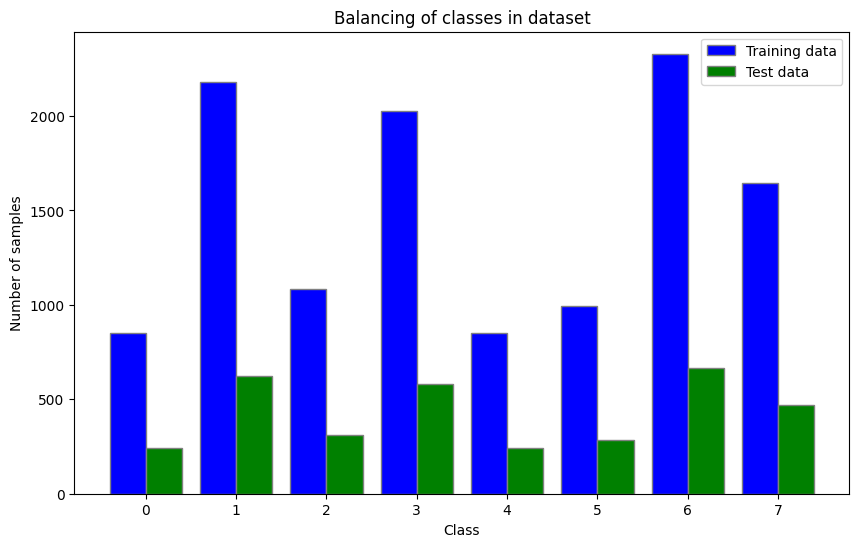

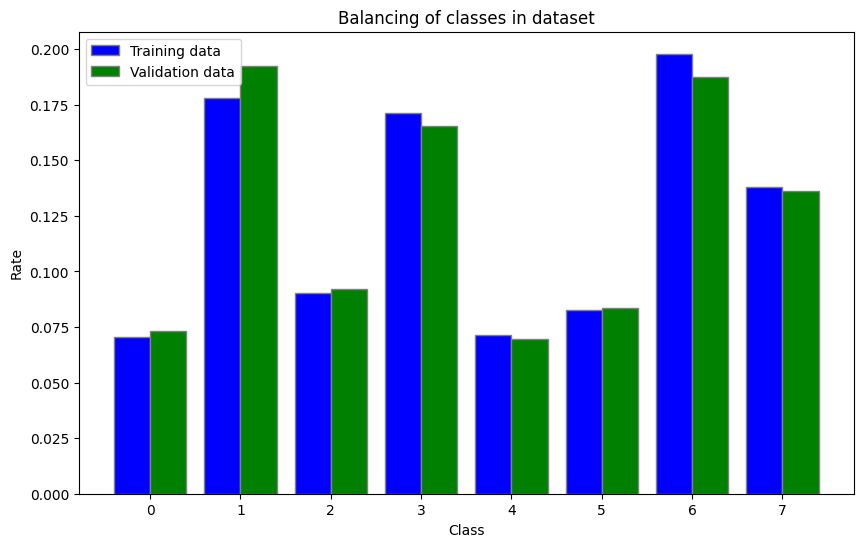

In [13]:
# Dataset balancing

train_one_hot = to_categorical(y_train_full)
test_one_hot =  to_categorical(y_test)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
test_balancing = np.sum(test_one_hot, axis=0)
test_balancing_norm = test_balancing/np.sum(test_balancing, axis=0)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, test_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Test data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Number of samples') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper right')

plt.savefig("../plot/Balancing_of_classes.pdf", format="pdf", bbox_inches="tight")

# Using holdout

train_one_hot = to_categorical(y_train)
val_one_hot =  to_categorical(y_val)
                                 
train_balancing = np.sum(train_one_hot, axis=0)
val_balancing = np.sum(val_one_hot, axis=0)

train_balancing = train_balancing/np.sum(train_balancing)
val_balancing = val_balancing/np.sum(val_balancing)

barWidth = 0.4

plt.figure(figsize=(10,6))
 
# Set position of bar on X axis 
br1 = np.arange(len(train_balancing)) 
br2 = [x + barWidth for x in br1] 
 
# Make the plot
plt.bar(br1, train_balancing, color ='b', width = barWidth, 
        edgecolor ='grey', label ='Training data') 
plt.bar(br2, val_balancing, color ='g', width = barWidth, 
        edgecolor ='grey', label ='Validation data') 
 
# Adding Xticks 
plt.xlabel('Class') 
plt.ylabel('Rate') 
plt.xticks([r + barWidth/2 for r in range(len(train_balancing))], 
        ['0', '1', '2', '3', '4', '5', '6', '7'])
plt.title('Balancing of classes in dataset')
 
plt.legend(loc='upper left')

plt.savefig("../plot/Balancing_of_classes_holdout.pdf", format="pdf", bbox_inches="tight")

In [10]:
def build_and_test_cnn(n_kernels=32, kernel_size=5, activation_fnc="relu", pooling="max", optimizer="sgd", epochs=300, verbose=1):
    
    tf.keras.backend.clear_session() # Free memory and clear old models in session
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=kernel_size, strides=1,
                                     padding="SAME", activation=activation_fnc, input_shape=(INPUT_N, INPUT_N, 3)))   
    if(pooling == "avg"):
        model.add(tf.keras.layers.AveragePooling2D(pool_size=2))
    if(pooling == "max"):
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, activation="softmax"))
    model.summary()
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/cnn_shallow/cnn_"+str(n_kernels)+"_"+str(kernel_size)+"x"+str(kernel_size)+"_"+(activation_fnc)+"_"+str(pooling)+"_"+(optimizer)+".weights.h5",
                                                    save_best_only=True, save_weights_only=True)
    
    history = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint_cb], verbose=verbose)
    
    model.load_weights("../model/cnn_shallow/cnn_"+str(n_kernels)+"_"+str(kernel_size)+"x"+str(kernel_size)+"_"+(activation_fnc)+"_"+str(pooling)+"_"+(optimizer)+".weights.h5")
    
    val_accuracy = max(history.history['val_accuracy'])
    
    val_loss = history.history['val_loss'][history.history['val_accuracy'].index(val_accuracy)]
    
    model_specs = dict(n_kernels=n_kernels,
                       kernel_size=kernel_size,
                       activation_fnc=activation_fnc,
                       pooling=pooling,
                       optimizer=optimizer,
                       loss=val_loss,
                       accuracy=val_accuracy)
    
    return model_specs, history, model

def restoreModel(n_kernels=32, kernel_size=5, activation_fnc="relu", pooling="max", optimizer="sgd"):
    tf.keras.backend.clear_session() # Free memory and clear old models in session
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=kernel_size, strides=1,
                                     padding="SAME", activation=activation_fnc, input_shape=(INPUT_N, INPUT_N, 3)))   
    if(pooling == "avg"):
        model.add(tf.keras.layers.AveragePooling2D(pool_size=2))
    if(pooling == "max"):
        model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, activation="softmax"))
    model.summary()
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    model.load_weights("../model/cnn_shallow/cnn_"+str(n_kernels)+"_"+str(kernel_size)+"x"+str(kernel_size)+"_"+(activation_fnc)+"_"+str(pooling)+"_"+(optimizer)+".weights.h5")
    
    return model

/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        50,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,616 (205.53 KB)

 Trainable params: 52,616 (205.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3069 - loss: 1.8402 - val_accuracy: 0.4936 - val_loss: 1.3604
Epoch 2/2
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5356 - loss: 1.2551 - val_accuracy: 0.6143 - val_loss: 1.0726
{'accuracy': 0.6142697930335999,
 'activation_fnc': 'relu',
 'kernel_size': 5,
 'loss': 1.0726261138916016,
 'n_kernels': 32,
 'optimizer': 'sgd',
 'pooling': 'max'}


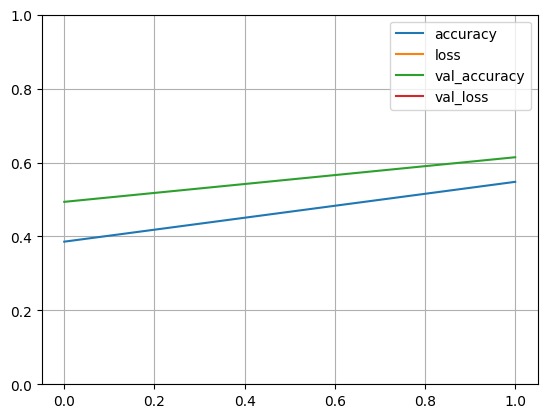

In [38]:
# Test custom model

model_specs, history, model = build_and_test_cnn(epochs=200, pooling="max", optimizer="sgd")

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.ylim([0,1])

pprint.pprint(model_specs)

In [4]:
epochs = 100

n_kernels_search = [8, 16, 32, 64, 128]

kernel_size_search = [3, 5, 7, 9]

In [5]:
############################################

models = []
historys = []

for kernel_size in kernel_size_search:

    for n_kernel in n_kernels_search:
        print("\n\n|++| Training for "+str(n_kernel)+" "+str(kernel_size)+"x"+str(kernel_size)+" kernels |++|\n")
        model_specs, history, _ = build_and_test_cnn(n_kernels=n_kernel,kernel_size=kernel_size, epochs=epochs, verbose=1)
        models.append(model_specs)
        historys.append(history)
        
        pprint.pprint(model_specs)
        
        models_backup = open("../model/cnn_shallow/models_search_backup.txt", "a")
        models_backup.write(str(model_specs)+'\n')
        models_backup.close()
        
    



|++| Training for 8 3x3 kernels |++|



/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-14 20:03:35.518901: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        12,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,776 (49.91 KB)

 Trainable params: 12,776 (49.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2969 - loss: 1.8512 - val_accuracy: 0.4632 - val_loss: 1.4281
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5065 - loss: 1.3181 - val_accuracy: 0.4763 - val_loss: 1.5739
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5919 - loss: 1.1207 - val_accuracy: 0.5730 - val_loss: 1.0679
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6337 - loss: 1.0091 - val_accuracy: 0.6572 - val_loss: 0.9588
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6745 - loss: 0.9213 - val_accuracy: 0.6848 - val_loss: 0.9153
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6846 - loss: 0.8932 - val_accuracy: 0.7168 - val_loss: 0.8162
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7174 - loss: 0.8458 - val_accuracy: 0.6583 - val_loss: 0.9107
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7148 - loss: 0.7998 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        25,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,544 (99.78 KB)

 Trainable params: 25,544 (99.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2668 - loss: 1.9025 - val_accuracy: 0.5153 - val_loss: 1.4685
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4851 - loss: 1.3728 - val_accuracy: 0.5945 - val_loss: 1.1154
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5744 - loss: 1.1475 - val_accuracy: 0.5847 - val_loss: 1.1206
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6118 - loss: 1.0402 - val_accuracy: 0.4883 - val_loss: 1.3187
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6357 - loss: 0.9978 - val_accuracy: 0.5412 - val_loss: 1.1319
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6595 - loss: 0.9393 - val_accuracy: 0.6533 - val_loss: 0.9659
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6789 - loss: 0.8918 - val_accuracy: 0.7235 - val_loss: 0.8250
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6995 - loss: 0.8571 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        50,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,080 (199.53 KB)

 Trainable params: 51,080 (199.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2921 - loss: 1.8566 - val_accuracy: 0.4936 - val_loss: 1.4836
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5030 - loss: 1.3214 - val_accuracy: 0.4431 - val_loss: 1.2877
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5995 - loss: 1.1086 - val_accuracy: 0.5911 - val_loss: 1.0455
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6079 - loss: 1.0445 - val_accuracy: 0.6446 - val_loss: 0.9969
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6436 - loss: 0.9666 - val_accuracy: 0.6182 - val_loss: 0.9504
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6735 - loss: 0.9013 - val_accuracy: 0.6502 - val_loss: 0.9212
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6892 - loss: 0.8851 - val_accuracy: 0.7246 - val_loss: 0.8072
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7113 - loss: 0.8152 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,152 (399.03 KB)

 Trainable params: 102,152 (399.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2822 - loss: 1.8558 - val_accuracy: 0.4582 - val_loss: 1.3537
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5132 - loss: 1.3123 - val_accuracy: 0.6394 - val_loss: 1.0776
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5926 - loss: 1.0833 - val_accuracy: 0.4593 - val_loss: 1.3379
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6246 - loss: 1.0125 - val_accuracy: 0.6745 - val_loss: 0.9091
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6665 - loss: 0.9398 - val_accuracy: 0.6870 - val_loss: 0.8540
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6864 - loss: 0.8691 - val_accuracy: 0.7009 - val_loss: 0.8730
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7039 - loss: 0.8367 - val_accuracy: 0.7310 - val_loss: 0.7808
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7284 - loss: 0.7907 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,296 (798.03 KB)

 Trainable params: 204,296 (798.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2936 - loss: 1.8334 - val_accuracy: 0.3849 - val_loss: 1.4041
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4962 - loss: 1.3077 - val_accuracy: 0.5761 - val_loss: 1.1294
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5941 - loss: 1.0970 - val_accuracy: 0.5348 - val_loss: 1.1505
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6364 - loss: 1.0033 - val_accuracy: 0.6639 - val_loss: 0.9456
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6513 - loss: 0.9485 - val_accuracy: 0.6873 - val_loss: 0.8815
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6900 - loss: 0.8618 - val_accuracy: 0.6781 - val_loss: 0.8703
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7030 - loss: 0.8425 - val_accuracy: 0.6544 - val_loss: 0.9550
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7110 - loss: 0.8228 - val_acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        12,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,160 (51.41 KB)

 Trainable params: 13,160 (51.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2983 - loss: 1.8488 - val_accuracy: 0.4802 - val_loss: 1.3649
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5229 - loss: 1.2501 - val_accuracy: 0.5438 - val_loss: 1.1884
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6048 - loss: 1.0755 - val_accuracy: 0.5365 - val_loss: 1.1694
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6499 - loss: 0.9561 - val_accuracy: 0.7023 - val_loss: 0.8747
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6889 - loss: 0.8774 - val_accuracy: 0.6407 - val_loss: 0.9062
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7224 - loss: 0.8105 - val_accuracy: 0.5630 - val_loss: 1.0800
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7421 - loss: 0.7592 - val_accuracy: 0.7188 - val_loss: 0.7803
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7430 - loss: 0.7386 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        25,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,312 (102.78 KB)

 Trainable params: 26,312 (102.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3059 - loss: 1.8276 - val_accuracy: 0.3930 - val_loss: 1.4286
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5343 - loss: 1.2455 - val_accuracy: 0.5438 - val_loss: 1.2442
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6023 - loss: 1.0777 - val_accuracy: 0.6098 - val_loss: 1.0752
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6443 - loss: 0.9737 - val_accuracy: 0.6658 - val_loss: 0.9276
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6616 - loss: 0.9321 - val_accuracy: 0.7246 - val_loss: 0.8212
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7096 - loss: 0.8422 - val_accuracy: 0.7018 - val_loss: 0.8492
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7254 - loss: 0.7865 - val_accuracy: 0.6887 - val_loss: 0.8301
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7391 - loss: 0.7615 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        50,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,616 (205.53 KB)

 Trainable params: 52,616 (205.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3093 - loss: 1.8097 - val_accuracy: 0.4339 - val_loss: 1.3159
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5472 - loss: 1.2295 - val_accuracy: 0.4863 - val_loss: 1.5138
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6024 - loss: 1.0773 - val_accuracy: 0.5817 - val_loss: 1.0890
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6585 - loss: 0.9477 - val_accuracy: 0.6555 - val_loss: 0.9262
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6832 - loss: 0.8862 - val_accuracy: 0.7135 - val_loss: 0.8146
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7178 - loss: 0.8321 - val_accuracy: 0.7271 - val_loss: 0.7983
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7354 - loss: 0.7836 - val_accuracy: 0.7522 - val_loss: 0.7071
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7411 - loss: 0.7472 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,224 (411.03 KB)

 Trainable params: 105,224 (411.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2884 - loss: 1.8585 - val_accuracy: 0.5780 - val_loss: 1.3304
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5226 - loss: 1.2603 - val_accuracy: 0.6566 - val_loss: 1.0059
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6079 - loss: 1.0510 - val_accuracy: 0.6321 - val_loss: 0.9579
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6665 - loss: 0.9531 - val_accuracy: 0.6290 - val_loss: 0.9472
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6992 - loss: 0.8542 - val_accuracy: 0.7205 - val_loss: 0.8163
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7138 - loss: 0.8168 - val_accuracy: 0.6982 - val_loss: 0.8204
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7459 - loss: 0.7448 - val_accuracy: 0.7539 - val_loss: 0.7094
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7582 - loss: 0.6974 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,440 (822.03 KB)

 Trainable params: 210,440 (822.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3065 - loss: 1.8167 - val_accuracy: 0.5053 - val_loss: 1.2842
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5347 - loss: 1.2412 - val_accuracy: 0.4830 - val_loss: 1.2674
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6127 - loss: 1.0358 - val_accuracy: 0.5914 - val_loss: 1.1204
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6518 - loss: 0.9543 - val_accuracy: 0.6569 - val_loss: 0.9629
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6892 - loss: 0.8835 - val_accuracy: 0.6767 - val_loss: 0.8733
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7190 - loss: 0.8049 - val_accuracy: 0.7508 - val_loss: 0.7489
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7444 - loss: 0.7511 - val_accuracy: 0.6898 - val_loss: 0.8006
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7564 - loss: 0.7060 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        12,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,736 (53.66 KB)

 Trainable params: 13,736 (53.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2665 - loss: 1.8708 - val_accuracy: 0.4540 - val_loss: 1.3429
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5146 - loss: 1.2921 - val_accuracy: 0.5596 - val_loss: 1.1777
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5859 - loss: 1.1082 - val_accuracy: 0.4889 - val_loss: 1.2829
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6320 - loss: 0.9862 - val_accuracy: 0.5864 - val_loss: 1.0871
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6811 - loss: 0.9090 - val_accuracy: 0.7191 - val_loss: 0.8085
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7068 - loss: 0.8347 - val_accuracy: 0.7361 - val_loss: 0.7676
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7272 - loss: 0.7687 - val_accuracy: 0.7545 - val_loss: 0.7115
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7430 - loss: 0.7385 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        25,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,464 (107.28 KB)

 Trainable params: 27,464 (107.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3269 - loss: 1.7962 - val_accuracy: 0.6028 - val_loss: 1.2093
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5316 - loss: 1.2075 - val_accuracy: 0.5563 - val_loss: 1.1907
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6045 - loss: 1.0578 - val_accuracy: 0.6603 - val_loss: 0.9327
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6846 - loss: 0.8863 - val_accuracy: 0.7104 - val_loss: 0.8738
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6991 - loss: 0.8421 - val_accuracy: 0.7232 - val_loss: 0.7920
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7361 - loss: 0.7724 - val_accuracy: 0.7377 - val_loss: 0.7127
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7561 - loss: 0.7052 - val_accuracy: 0.7584 - val_loss: 0.7026
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7685 - loss: 0.6822 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        50,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,920 (214.53 KB)

 Trainable params: 54,920 (214.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3089 - loss: 1.8181 - val_accuracy: 0.5098 - val_loss: 1.3829
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5447 - loss: 1.2197 - val_accuracy: 0.6157 - val_loss: 1.0459
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6204 - loss: 1.0352 - val_accuracy: 0.7007 - val_loss: 0.8828
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6728 - loss: 0.9272 - val_accuracy: 0.6806 - val_loss: 0.9103
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7049 - loss: 0.8557 - val_accuracy: 0.7269 - val_loss: 0.7798
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7334 - loss: 0.7854 - val_accuracy: 0.7344 - val_loss: 0.7478
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7493 - loss: 0.7261 - val_accuracy: 0.7620 - val_loss: 0.6736
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7608 - loss: 0.6914 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,832 (429.03 KB)

 Trainable params: 109,832 (429.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3187 - loss: 1.8041 - val_accuracy: 0.4306 - val_loss: 1.3927
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5386 - loss: 1.2182 - val_accuracy: 0.5259 - val_loss: 1.1061
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6115 - loss: 1.0330 - val_accuracy: 0.5666 - val_loss: 1.1931
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6743 - loss: 0.9298 - val_accuracy: 0.7227 - val_loss: 0.8164
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7023 - loss: 0.8421 - val_accuracy: 0.5435 - val_loss: 1.1854
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7390 - loss: 0.7786 - val_accuracy: 0.7283 - val_loss: 0.7834
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7394 - loss: 0.7396 - val_accuracy: 0.7441 - val_loss: 0.7243
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7641 - loss: 0.6794 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,656 (858.03 KB)

 Trainable params: 219,656 (858.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3265 - loss: 1.7810 - val_accuracy: 0.5683 - val_loss: 1.2418
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5513 - loss: 1.1974 - val_accuracy: 0.5106 - val_loss: 1.1419
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6120 - loss: 1.0531 - val_accuracy: 0.6881 - val_loss: 0.8792
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6673 - loss: 0.9104 - val_accuracy: 0.5555 - val_loss: 1.0646
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7052 - loss: 0.8345 - val_accuracy: 0.6926 - val_loss: 0.8370
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7297 - loss: 0.7674 - val_accuracy: 0.7174 - val_loss: 0.7466
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7579 - loss: 0.7124 - val_accuracy: 0.7623 - val_loss: 0.6653
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7682 - loss: 0.6776 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)      │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        12,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,504 (56.66 KB)

 Trainable params: 14,504 (56.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3118 - loss: 1.7918 - val_accuracy: 0.6120 - val_loss: 1.2642
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5667 - loss: 1.1713 - val_accuracy: 0.6486 - val_loss: 1.0405
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6161 - loss: 1.0215 - val_accuracy: 0.6820 - val_loss: 0.8882
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6795 - loss: 0.8979 - val_accuracy: 0.7076 - val_loss: 0.8255
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7097 - loss: 0.8354 - val_accuracy: 0.7051 - val_loss: 0.8580
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7385 - loss: 0.7680 - val_accuracy: 0.6853 - val_loss: 0.8136
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7500 - loss: 0.7227 - val_accuracy: 0.7397 - val_loss: 0.7441
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7593 - loss: 0.6904 - val_acc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        25,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,000 (113.28 KB)

 Trainable params: 29,000 (113.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3085 - loss: 1.8095 - val_accuracy: 0.4206 - val_loss: 1.3299
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5277 - loss: 1.2439 - val_accuracy: 0.6600 - val_loss: 1.0017
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6317 - loss: 1.0215 - val_accuracy: 0.6477 - val_loss: 0.9938
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6748 - loss: 0.9116 - val_accuracy: 0.7110 - val_loss: 0.8228
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7115 - loss: 0.8393 - val_accuracy: 0.6951 - val_loss: 0.8558
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7277 - loss: 0.7782 - val_accuracy: 0.7489 - val_loss: 0.7182
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7490 - loss: 0.7437 - val_accuracy: 0.7447 - val_loss: 0.6945
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7680 - loss: 0.6847 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        50,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,992 (226.53 KB)

 Trainable params: 57,992 (226.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3100 - loss: 1.7972 - val_accuracy: 0.4702 - val_loss: 1.2514
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5437 - loss: 1.1981 - val_accuracy: 0.3804 - val_loss: 1.9470
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6208 - loss: 1.0219 - val_accuracy: 0.7065 - val_loss: 0.8716
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6798 - loss: 0.8972 - val_accuracy: 0.6747 - val_loss: 0.8559
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7234 - loss: 0.7946 - val_accuracy: 0.7344 - val_loss: 0.7762
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7511 - loss: 0.7300 - val_accuracy: 0.7547 - val_loss: 0.6916
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7538 - loss: 0.7154 - val_accuracy: 0.7798 - val_loss: 0.6527
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7711 - loss: 0.6663 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,976 (453.03 KB)

 Trainable params: 115,976 (453.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3283 - loss: 1.7741 - val_accuracy: 0.5190 - val_loss: 1.3826
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5391 - loss: 1.2117 - val_accuracy: 0.5959 - val_loss: 0.9983
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6197 - loss: 1.0108 - val_accuracy: 0.6898 - val_loss: 0.8879
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6782 - loss: 0.8896 - val_accuracy: 0.7062 - val_loss: 0.8044
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7290 - loss: 0.7866 - val_accuracy: 0.6976 - val_loss: 0.8426
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7477 - loss: 0.7204 - val_accuracy: 0.6957 - val_loss: 0.8088
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7671 - loss: 0.6812 - val_accuracy: 0.7801 - val_loss: 0.6548
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7839 - loss: 0.6411 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       200,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,944 (906.03 KB)

 Trainable params: 231,944 (906.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3275 - loss: 1.7588 - val_accuracy: 0.3445 - val_loss: 1.6953
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5314 - loss: 1.2313 - val_accuracy: 0.5959 - val_loss: 1.0873
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6332 - loss: 0.9951 - val_accuracy: 0.5778 - val_loss: 1.0486
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6840 - loss: 0.8825 - val_accuracy: 0.6934 - val_loss: 0.8873
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7316 - loss: 0.7984 - val_accuracy: 0.7260 - val_loss: 0.7831
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7507 - loss: 0.7135 - val_accuracy: 0.7391 - val_loss: 0.7370
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7805 - loss: 0.6748 - val_accuracy: 0.7480 - val_loss: 0.7020
Epoch 8/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7807 - loss: 0.6426 - 

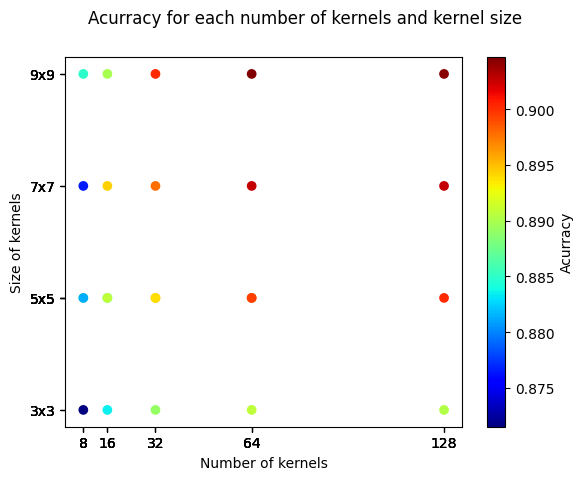

In [22]:
n_kernel = []
kernel_size = []
acurracy = []
label = []

models_backup = open("../model/cnn_shallow/models_search_backup.txt", "r")

models = models_backup.readlines()
models = [eval(i) for i in models]

for model in models:
    n_kernel.append(model["n_kernels"])
    kernel_size.append(model["kernel_size"])
    acurracy.append(model["accuracy"])
    label.append(str(model["kernel_size"])+"x"+str(model["kernel_size"]))

plt.figure
plt.scatter(n_kernel,kernel_size,c=acurracy, cmap=plt.cm.jet)
plt.yticks(ticks=kernel_size, labels=label)
plt.xticks(ticks=n_kernel, labels=n_kernel)
plt.colorbar(label="Acurracy")
plt.xlabel("Number of kernels")
plt.ylabel("Size of kernels")
plt.suptitle("Acurracy for each number of kernels and kernel size")
plt.savefig("../plot/cnn_shallow/hiper_parameters_search.pdf", format="pdf", bbox_inches="tight")

    

Winner model: 64 kernels, 9x9

In [23]:
epochs = 200
best_n_kernels = 64
best_kernel_size = 9

model_specs, history, model = build_and_test_cnn(n_kernels=best_n_kernels, 
                                                 kernel_size=best_kernel_size, 
                                                 epochs=epochs, verbose=1)

/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,976 (453.03 KB)

 Trainable params: 115,976 (453.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3389 - loss: 1.7730 - val_accuracy: 0.4030 - val_loss: 1.6053
Epoch 2/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5461 - loss: 1.2165 - val_accuracy: 0.6575 - val_loss: 0.9604
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6330 - loss: 1.0065 - val_accuracy: 0.6959 - val_loss: 0.8919
Epoch 4/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6853 - loss: 0.8796 - val_accuracy: 0.6742 - val_loss: 0.8569
Epoch 5/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7201 - loss: 0.8042 - val_accuracy: 0.7249 - val_loss: 0.7465
Epoch 6/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7400 - loss: 0.7501 - val_accuracy: 0.7023 - val_loss: 0.7977
Epoch 7/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7623 - loss: 0.7156 - val_accuracy: 0.7717 - val_loss: 0.6638
Epoch 8/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7820 - loss: 0.6476 - val_accu

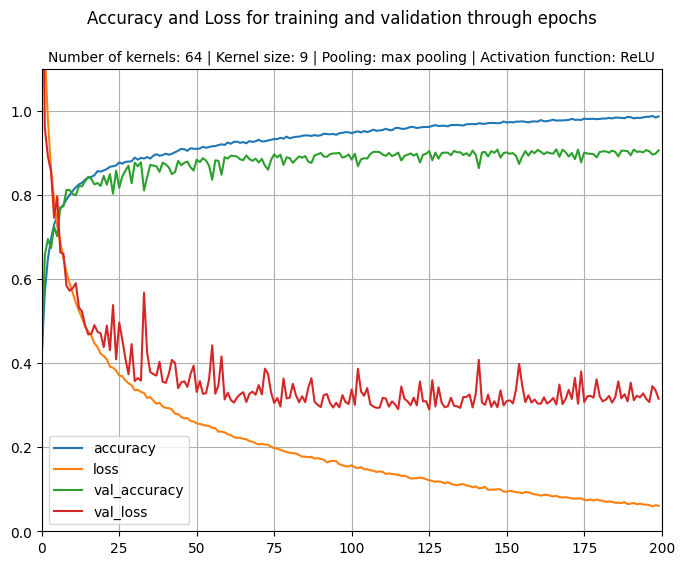

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.ylim([0,1.1])
plt.xlim([0,epochs])
plt.suptitle("Accuracy and Loss for training and validation through epochs", fontsize=12)
plt.title('Number of kernels: '+str(best_n_kernels)+
        ' | Kernel size: '+str(best_kernel_size)+
        ' | Pooling: max pooling'+
        ' | Activation function: ReLU',fontsize=10)

plt.savefig("../plot/cnn_shallow/best_model_training.pdf",
            format="pdf", bbox_inches="tight")

In [25]:
def rateModel(y,y_hat,classes_rate):
    
    hit = np.zeros(8)
    confusion_matrix = np.zeros([8,8])
    
    for i in range(len(y)):
        confusion_matrix[y[i], y_hat[i]] += 1
        
        hit[y[i]] += 1 if y[i] == y_hat[i] else 0
            
    ba = np.average(hit/(classes_rate*len(y)))
        
    return confusion_matrix, ba

def confusionMatrixExtract(confusion_matrix):
    score = {0 : {'Precision': 0, 'Recall': 0}, 
             1 : {'Precision': 0, 'Recall': 0}, 
             2 : {'Precision': 0, 'Recall': 0},
             3 : {'Precision': 0, 'Recall': 0},
             4 : {'Precision': 0, 'Recall': 0},
             5 : {'Precision': 0, 'Recall': 0},
             6 : {'Precision': 0, 'Recall': 0},
             7 : {'Precision': 0, 'Recall': 0}}
    
    for i in range(8):
        TP = FP = FN = 0
        for j in range(8):
            TP = confusion_matrix[i][j] if i == j else TP
            FP += confusion_matrix[i][j] if i != j else 0
            FN += confusion_matrix[j][i] if i != j else 0
            
        score[i]['Precision']= TP/(TP+FP)
        score[i]['Recall']= TP/(TP+FN)
    
    return score

In [26]:
model = restoreModel(n_kernels=best_n_kernels, kernel_size=best_kernel_size)

loss, accuracy = model.evaluate(X_test,y_test)

y_hat_test_ohe = model.predict_on_batch(X_test)

y_hat_test = np.argmax(y_hat_test_ohe, axis=1)

confusion_matrix, ba = rateModel(np.uint8(np.squeeze(y_test)), y_hat_test, test_balancing_norm)

score = confusionMatrixExtract(confusion_matrix)

print('confusion_matrix = \n'+str(confusion_matrix))

print('\nAccuracy = '+str(accuracy))

print('\nBA = '+str(ba)+"\n")

print("Class | Precision | Recall")
for i in range(8):
    print(str(i)+'\t'+str("{:.4f}".format(score[i]['Precision']))+'\t'+str("{:.4f}".format(score[i]['Recall'])))

/home/toffanetto/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,976 (453.03 KB)

 Trainable params: 115,976 (453.03 KB)

 Non-trainable params: 0 (0.00 B)

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9025 - loss: 0.2967
confusion_matrix = 
[[193.   2.   1.  34.   4.  10.   0.   0.]
 [  2. 610.   0.   4.   1.   1.   6.   0.]
 [  3.   2. 286.   9.   2.   3.   4.   2.]
 [ 23.  12.  14. 478.  13.  21.  18.   0.]
 [  9.   0.   6.  12. 214.   1.   1.   0.]
 [  4.   0.   4.  50.   6. 219.   1.   0.]
 [  1.   7.   2.  14.   2.   0. 640.   0.]
 [  0.   0.   0.   0.   0.   0.   1. 469.]]

Accuracy = 0.9087985754013062

BA = 0.8905427084754072

Class | Precision | Recall
0	0.7910	0.8213
1	0.9776	0.9637
2	0.9196	0.9137
3	0.8256	0.7953
4	0.8807	0.8843
5	0.7711	0.8588
6	0.9610	0.9538
7	0.9979	0.9958


|++  36  ++|
Predicted class: 3
     Real class: 0
Probilites for each class: 
	(3, 0.75724095)
	(0, 0.21884961)
	(5, 0.019445756)
	(1, 0.0018889878)
	(6, 0.0015585176)
	(4, 0.0010069764)
	(2, 9.147916e-06)
	(7, 1.6962028e-10)



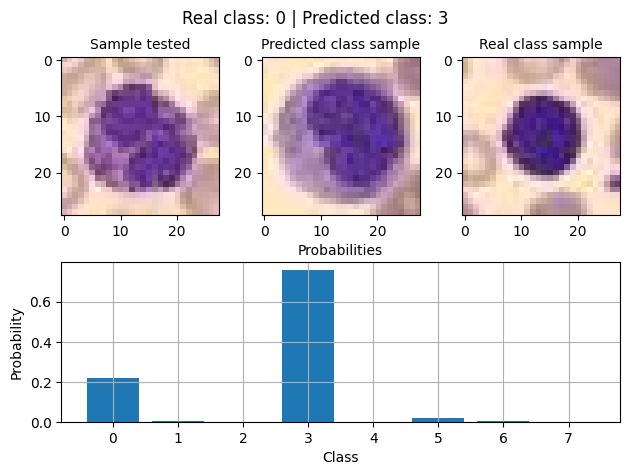

|++  1455  ++|
Predicted class: 5
     Real class: 3
Probilites for each class: 
	(5, 0.45544365)
	(3, 0.34554642)
	(6, 0.13977113)
	(0, 0.037580848)
	(4, 0.021403892)
	(2, 0.00023340013)
	(1, 2.055962e-05)
	(7, 1.7205283e-08)



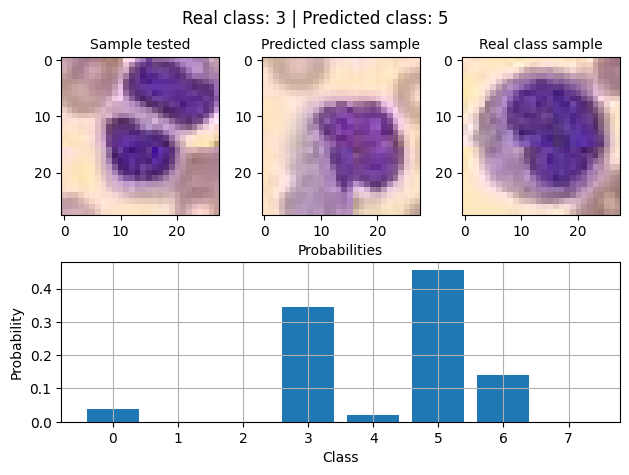

|++  1516  ++|
Predicted class: 6
     Real class: 1
Probilites for each class: 
	(6, 0.36540857)
	(0, 0.25337195)
	(3, 0.20120397)
	(1, 0.17994146)
	(5, 4.3581247e-05)
	(4, 2.0447187e-05)
	(2, 9.803897e-06)
	(7, 1.4583084e-07)



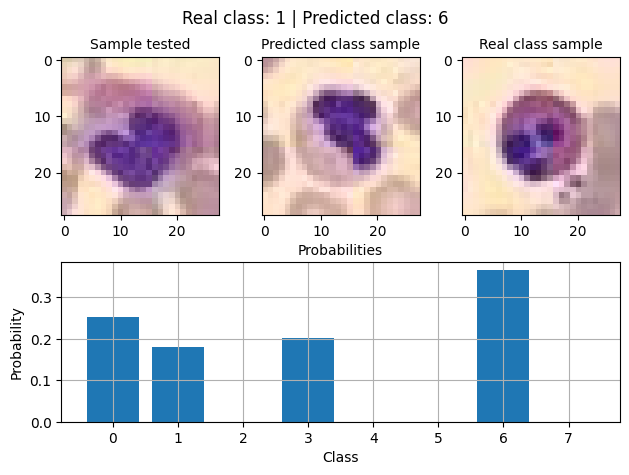

|++  35  ++|
Predicted class: 3
     Real class: 6
Probilites for each class: 
	(3, 0.4250543)
	(0, 0.21231896)
	(4, 0.2000293)
	(6, 0.13348866)
	(5, 0.027078932)
	(2, 0.0012607876)
	(1, 0.00076579116)
	(7, 3.226537e-06)



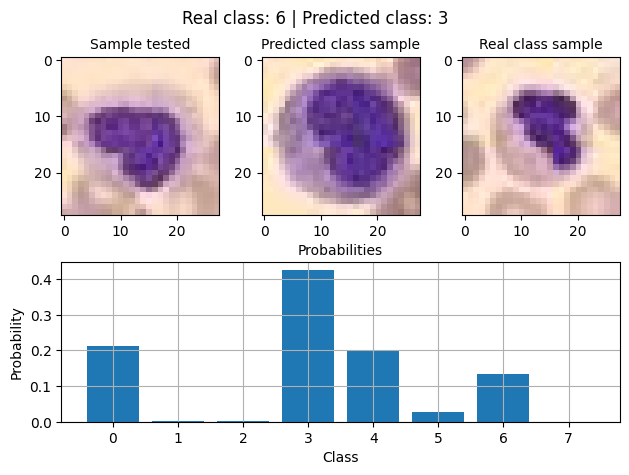

|++  62  ++|
Predicted class: 2
     Real class: 6
Probilites for each class: 
	(2, 0.8851864)
	(6, 0.114251584)
	(3, 0.00033975206)
	(7, 0.00021148987)
	(4, 9.607484e-06)
	(5, 1.1017612e-06)
	(0, 5.513563e-08)
	(1, 4.284303e-09)



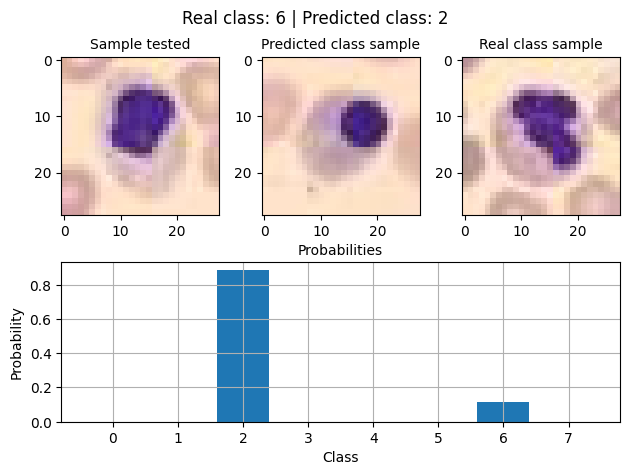

In [32]:
y_train_list = y_train[:,0].tolist()

class_samples = [y_train_list.index(i) for i in range(8)]

for i in [36, 1455, 1516, 35, 62]:
    if y_hat_test[i] != y_test[i]:
        print("|++  "+str(i)+"  ++|")
        print("Predicted class: "+str(y_hat_test[i]))
        print("     Real class: "+str(int(y_test[i,0])))
        prob = sorted(list(enumerate(y_hat_test_ohe[i])),key=lambda tup: tup[1], reverse=True)
        s = ""
        for j in range(8):
            s += "\t"+str(prob[j])+"\n" 
        print("Probilites for each class: \n"+s)
                
        plt.figure()        
        plt.subplot(2,3,1)
        plt.imshow(X_test[i])
        plt.title("Sample tested",fontsize=10)
        plt.subplot(2,3,2)
        plt.imshow(X_train[class_samples[y_hat_test[i]]])
        plt.title("Predicted class sample",fontsize=10)
        plt.subplot(2,3,3)
        plt.imshow(X_train[class_samples[int(y_test[i,0])]])
        plt.title("Real class sample",fontsize=10)
        plt.subplot(2,3,(4,6))
        plt.bar(x=[0, 1, 2, 3, 4, 5, 6, 7],height=y_hat_test_ohe[i])
        plt.title("Probabilities",fontsize=10)
        plt.grid()
        plt.ylabel("Probability")
        plt.xlabel("Class")
        plt.suptitle("Real class: "+str(int(y_test[i,0]))+" | Predicted class: "+str(y_hat_test[i]))
        plt.tight_layout()
        plt.savefig("../plot/cnn_shallow/error_analyser_"+str(i)+".pdf", format="pdf", bbox_inches="tight")
        plt.show()

---
### Using 28x28 data size convolutional layer in greater data training only the output layer
---

In [59]:
tf.keras.backend.clear_session() # Free memory and clear old models in session
    
input = tf.keras.Input(shape=(INPUT_N, INPUT_N, 3))
    
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=9, strides=1,
                                    padding="SAME", activation="relu"))   
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.summary()

# model_cnn.compile(loss="sparse_categorical_crossentropy",
#                 optimizer="sgd",
#                 metrics=["accuracy"])

softmax = tf.keras.layers.Dense(8, activation="softmax")

x = model_cnn(input)
output = softmax(x)

model = tf.keras.Model(input, output)

model.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

model.summary()

checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/cnn_shallow/cnn_"+str(64)+"_"+str(9)+"x"+str(9)+"conv.weights.h5",
                                                save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb], verbose=1)

model.load_weights("../model/cnn_shallow/cnn_"+str(64)+"_"+str(9)+"x"+str(9)+"conv.weights.h5")

loss, accuracy = model.evaluate(X_test,y_test)

print('\n=========================')
print('accuracy = '+str(accuracy))
print('=========================\n')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 12544)          │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,976 (453.03 KB)

 Trainable params: 115,976 (453.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3220 - loss: 1.7690 - val_accuracy: 0.5114 - val_loss: 1.2578
Epoch 2/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5418 - loss: 1.2062 - val_accuracy: 0.6469 - val_loss: 0.9887
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6284 - loss: 1.0059 - val_accuracy: 0.7062 - val_loss: 0.8777
Epoch 4/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6810 - loss: 0.9078 - val_accuracy: 0.7113 - val_loss: 0.8103
Epoch 5/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7093 - loss: 0.8099 - val_accuracy: 0.7455 - val_loss: 0.7484
Epoch 6/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7418 - loss: 0.7415 - val_accuracy: 0.7492 - val_loss: 0.7282
Epoch 7/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7653 - loss: 0.6838 - val_accuracy: 0.7606 - val_loss: 0.6924
Epoch 8/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7733 - loss: 0.6609 - val_accu

In [64]:
model_cnn.summary()
model_cnn.save_weights('../model/cnn_shallow/conv_layer.weights.h5')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
INPUT_N = 64

train_dataset = BloodMNIST(split="train", download=True, size=INPUT_N)

X_train_full = np.zeros([len(train_dataset), INPUT_N, INPUT_N, 3]) 

y_train_full = np.zeros([len(train_dataset), 1])

for i in range(len(train_dataset)):
    x, y_train_full[i] = train_dataset[i]
    X_train_full[i] = np.array(x)/255.0
    
i_val = int(len(train_dataset)*0.7)

X_train = X_train_full[:i_val]
y_train = y_train_full[:i_val]

X_val = X_train_full[i_val:]
y_val = y_train_full[i_val:]

print('Number of samples in train dataset: '+str(len(train_dataset)))

print('Shape of data in train dataset: '+str(X_train.shape)+" "+str(y_train.shape))

print('Shape of data in validation dataset: '+str(X_val.shape)+" "+str(y_val.shape))

test_dataset = BloodMNIST(split="test", download=True, size=INPUT_N)

X_test = np.zeros([len(test_dataset), INPUT_N, INPUT_N, 3])

y_test = np.zeros([len(test_dataset), 1])

for i in range(len(test_dataset)):
    x, y_test[i] = test_dataset[i]
    X_test[i] = np.array(x)/255.0


Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist_64.npz
Number of samples in train dataset: 11959
Shape of data in train dataset: (8371, 64, 64, 3) (8371, 1)
Shape of data in validation dataset: (3588, 64, 64, 3) (3588, 1)
Using downloaded and verified file: /home/toffanetto/.medmnist/bloodmnist_64.npz


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 65536)          │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │       524,296 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,912 (2.06 MB)

 Trainable params: 524,296 (2.00 MB)

 Non-trainable params: 15,616 (61.00 KB)

Epoch 1/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2808 - loss: 2.3163 - val_accuracy: 0.3116 - val_loss: 2.0737
Epoch 2/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4657 - loss: 1.5894 - val_accuracy: 0.4705 - val_loss: 1.4270
Epoch 3/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5418 - loss: 1.2825 - val_accuracy: 0.4033 - val_loss: 1.4519
Epoch 4/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5710 - loss: 1.1822 - val_accuracy: 0.6171 - val_loss: 0.9922
Epoch 5/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6260 - loss: 1.0291 - val_accuracy: 0.6499 - val_loss: 0.9473
Epoch 6/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6460 - loss: 0.9808 - val_accuracy: 0.5858 - val_loss: 1.1012
Epoch 7/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6584 - loss: 0.9465 - val_accuracy: 0.6229 - val_loss: 1.0719
Epoch 8/200
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6487 - loss: 0.9878 - val_acc

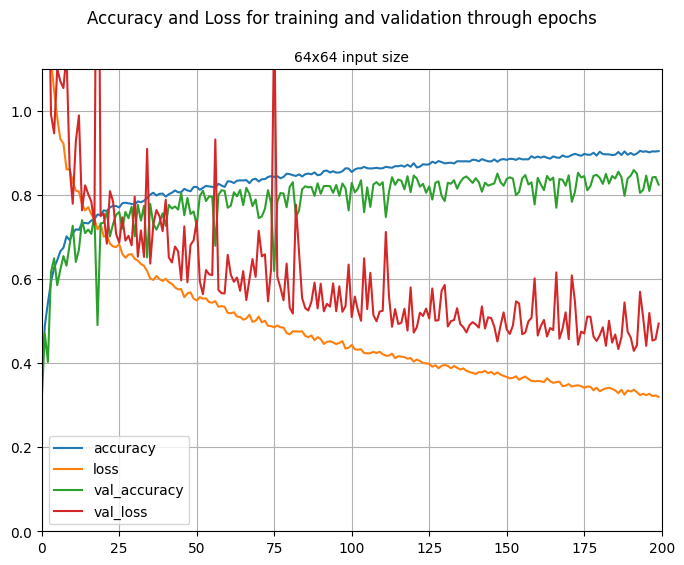

In [65]:
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=9, strides=1,
                                    padding="SAME", activation="relu"))   
model_cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_cnn.add(tf.keras.layers.Flatten())

model_cnn.load_weights('../model/cnn_shallow/conv_layer.weights.h5')
model_cnn.summary()

model_cnn.trainable = False

input = tf.keras.Input(shape=(INPUT_N, INPUT_N, 3))

softmax = tf.keras.layers.Dense(8, activation="softmax")

x = model_cnn(input, training=False)
output = softmax(x)

model = tf.keras.Model(input, output)

model.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

model.summary()

checkpoint_cb = keras.callbacks.ModelCheckpoint("../model/cnn_shallow/cnn_"+str(64)+"_"+str(9)+"x"+str(9)+"conv.weights.h5",
                                                save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb], verbose=1)

model.load_weights("../model/cnn_shallow/cnn_"+str(64)+"_"+str(9)+"x"+str(9)+"conv.weights.h5")

pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.ylim([0,1.1])
plt.xlim([0,epochs])
plt.suptitle("Accuracy and Loss for training and validation through epochs", fontsize=12)
plt.title('64x64 input size',fontsize=10)

plt.savefig("../plot/cnn_shallow/64x64_model_training.pdf",
            format="pdf", bbox_inches="tight")

loss, accuracy = model.evaluate(X_test,y_test)

print('\n=========================')
print('accuracy = '+str(accuracy))
print('=========================\n')